<a href="https://colab.research.google.com/github/knlpscience/Traffic-Accident-Injury-Prediction-Competition/blob/main/%EB%8C%80%EA%B5%AC_%EA%B5%90%ED%86%B5%EC%82%AC%EA%B3%A0_%ED%94%BC%ED%95%B4_%EC%98%88%EC%B8%A1_AI_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C(model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

import pandas as pd
import numpy as np
import bisect
from tqdm import tqdm

import lightgbm as lgb
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

Model Tune for LGBM.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 553
[LightGBM] [Info] Number of data points in the train set: 39609, number of used features: 11
[LightGBM] [Info] Start training from score 4.726704


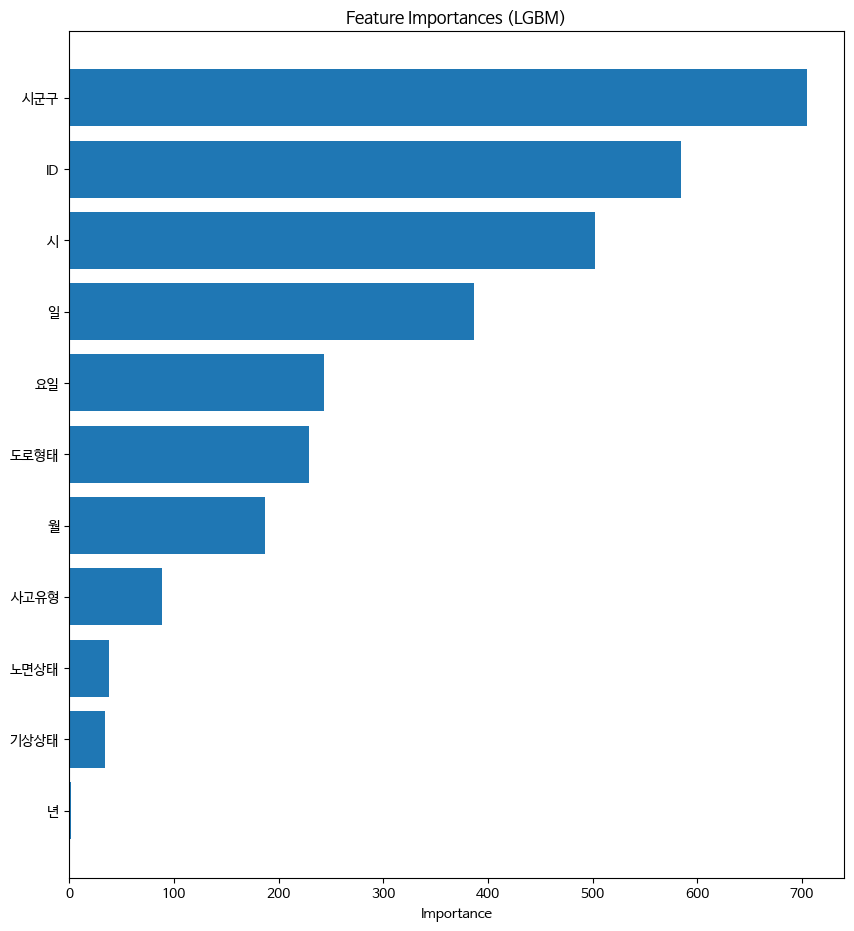

In [41]:
PATH = '/content/drive/MyDrive/Colab Notebooks/DACON/교통사고 data/'

# 데이터 로딩 함수
def load_data(filename):
    return pd.read_csv(f'{PATH}{filename}')

# 날짜 처리 함수
def process_date(df):
    df['사고일시'] = pd.to_datetime(df['사고일시'])
    df['년'] = df['사고일시'].dt.year
    df['월'] = df['사고일시'].dt.month
    df['일'] = df['사고일시'].dt.day
    df['시'] = df['사고일시'].dt.hour
    df.drop(columns='사고일시', inplace=True)

# 인코딩 함수
def encode_categorical(df, encoders=None):
    if encoders is None:
        encoders = {}
    categorical_features = df.select_dtypes(include=['object']).columns
    for feature in categorical_features:
        if feature not in encoders:
            le = LabelEncoder()
            df[feature] = le.fit_transform(df[feature].astype(str))
            encoders[feature] = le
        else:
            le = encoders[feature]
            # Handling unseen labels
            df[feature] = df[feature].apply(lambda x: x if x in le.classes_ else '-1')
            le_classes = le.classes_.tolist()
            bisect.insort_left(le_classes, '-1')
            le.classes_ = np.array(le_classes)
            df[feature] = le.transform(df[feature].astype(str))
    return df, encoders


# 결측치 처리 함수
def impute_missing_values(df, strategy='mean'):
    for column in df.columns:
        if df[column].isnull().any():
            if strategy == 'mean':
                df[column].fillna(df[column].mean(), inplace=True)
            # 다른 전략들을 추가할 수 있음
    return df

# 데이터 로딩
train = load_data('train.csv')
test_df = load_data('test.csv')

test_columns = set(test_df.columns)
train_df = train[test_columns]

# 데이터 전처리
process_date(train_df)
process_date(test_df)

# 카테고리 변수 처리
train_df, encoders = encode_categorical(train_df)
test_df, _ = encode_categorical(test_df, encoders)

# 결측치 처리
train_df = impute_missing_values(train_df)
test_df = impute_missing_values(test_df)

# 피처와 타깃 분리
X_train = train_df
y_train = train['ECLO']


def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

# 모델 학습 및 평가
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

In [39]:
threshold = 85
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test_df.drop(columns=low_importance_features)

In [40]:
lgbm = lgb.LGBMRegressor(n_estimators=100)

# 5-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

ensemble_predictions = []
train_scores = []
val_scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 학습
    lgbm.fit(X_t, y_t)

    # 예측
    train_pred = lgbm.predict(X_t)
    val_pred = lgbm.predict(X_val)

    # 음수 보정
    train_pred = np.where(train_pred < 0, 0, train_pred)
    val_pred = np.where(val_pred < 0, 0, val_pred)

    # loss
    train_scores.append(np.sqrt(mean_squared_log_error(y_t, train_pred)))
    val_scores.append(np.sqrt(mean_squared_log_error(y_val, val_pred)))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    ensemble_predictions.append(lgbm_pred)

# fold별 모델들의 앙상블 예측
final_predictions = np.mean(ensemble_predictions, axis=0)

# loss 평균
print("Train : RMSLE:", np.mean(train_scores))
print("Validation : RMSLE:", np.mean(val_scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 538
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 8
[LightGBM] [Info] Start training from score 4.732382


Processing folds:  20%|██        | 1/5 [00:00<00:01,  2.05it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 541
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 8
[LightGBM] [Info] Start training from score 4.733140


Processing folds:  40%|████      | 2/5 [00:01<00:01,  1.97it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 539
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 8
[LightGBM] [Info] Start training from score 4.714520


Processing folds:  60%|██████    | 3/5 [00:01<00:01,  1.97it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 8
[LightGBM] [Info] Start training from score 4.721810


Processing folds:  80%|████████  | 4/5 [00:01<00:00,  2.07it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 538
[LightGBM] [Info] Number of data points in the train set: 31688, number of used features: 8
[LightGBM] [Info] Start training from score 4.731665


Processing folds: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

Train : RMSLE: 0.43904692136494017
Validation : RMSLE: 0.46044620323751884


In [31]:
submit = pd.read_csv(f'{PATH}sample_submission.csv')
submit['ECLO'] = final_predictions
submit.to_csv(f'submission.csv', index=False)